# Functions for Generating Custom Masks

In [1]:
import os
import numpy as np
import SimpleITK as sitk
from scipy.ndimage import shift
from scipy.ndimage import map_coordinates
import glob
from tqdm import tqdm
from multiprocessing import Pool
import matplotlib.pyplot as plt

In [2]:
input_directory = "dataset/whole_head/mask/"

### 1. Scale tumor mask relative to tumor center within head mask area, with specified range and number of output images:

In [3]:
def scale_tumor_part(args):
    """
    Scales the tumor part of a given mask by a specified scale factor.

    :param args: Tuple containing (output_directory, mask_path, scale).
    """
    output_directory, mask_path, scale = args
    name = os.path.basename(mask_path)
    img = sitk.ReadImage(mask_path)
    img_array = sitk.GetArrayFromImage(img)

    tumor_mask = img_array == 2
    tumor_positions = np.argwhere(tumor_mask)
    center_of_tumor = tumor_positions.mean(axis=0)

    coords = np.indices(img_array.shape).reshape(3, -1)
    coords_shifted = coords - np.expand_dims(center_of_tumor, axis=1)

    scaled_coords = coords_shifted / scale + np.expand_dims(center_of_tumor, axis=1)
    transformed_tumor = map_coordinates(tumor_mask, scaled_coords, order=0, mode='constant').reshape(img_array.shape)

    transformed_tumor_mask = np.round(transformed_tumor).astype(int).clip(0, 1)
    brain_mask = img_array == 1
    brain_mask[img_array == 2] = 1
    final_mask = brain_mask + 2 * transformed_tumor_mask
    final_mask[final_mask == 3] = 2

    val, counts = np.unique(final_mask, return_counts=True)
    if len(counts) >= 3 and counts[2] >= 30:
        final_mask_img = sitk.GetImageFromArray(final_mask)
        final_mask_img.CopyInformation(img)
        sitk.WriteImage(final_mask_img, os.path.join(output_directory, f"{scale}_{name}"))

def process_masks(input_directory, output_directory, scale_start, scale_end, num_scales):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    scales = np.linspace(scale_start, scale_end, num_scales)
    mask_list = sorted(glob.glob(os.path.join(input_directory, "*.nii.gz")))

    # Prepare arguments for parallel processing
    args = [(output_directory, mask, scale) for mask in mask_list for scale in scales]

    # Use multiprocessing pool to process images in parallel
    with Pool() as pool:
        list(tqdm(pool.imap(scale_tumor_part, args), total=len(args)))

scale_start = 2.0
scale_end = 0.5
num_scales = 20
output_directory = "dataset/scaled_masks"
process_masks(input_directory, output_directory, scale_start, scale_end, num_scales)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 27.55it/s]


#### Largest tumor slice in original image for axial plane comparative plotting with all scaled images

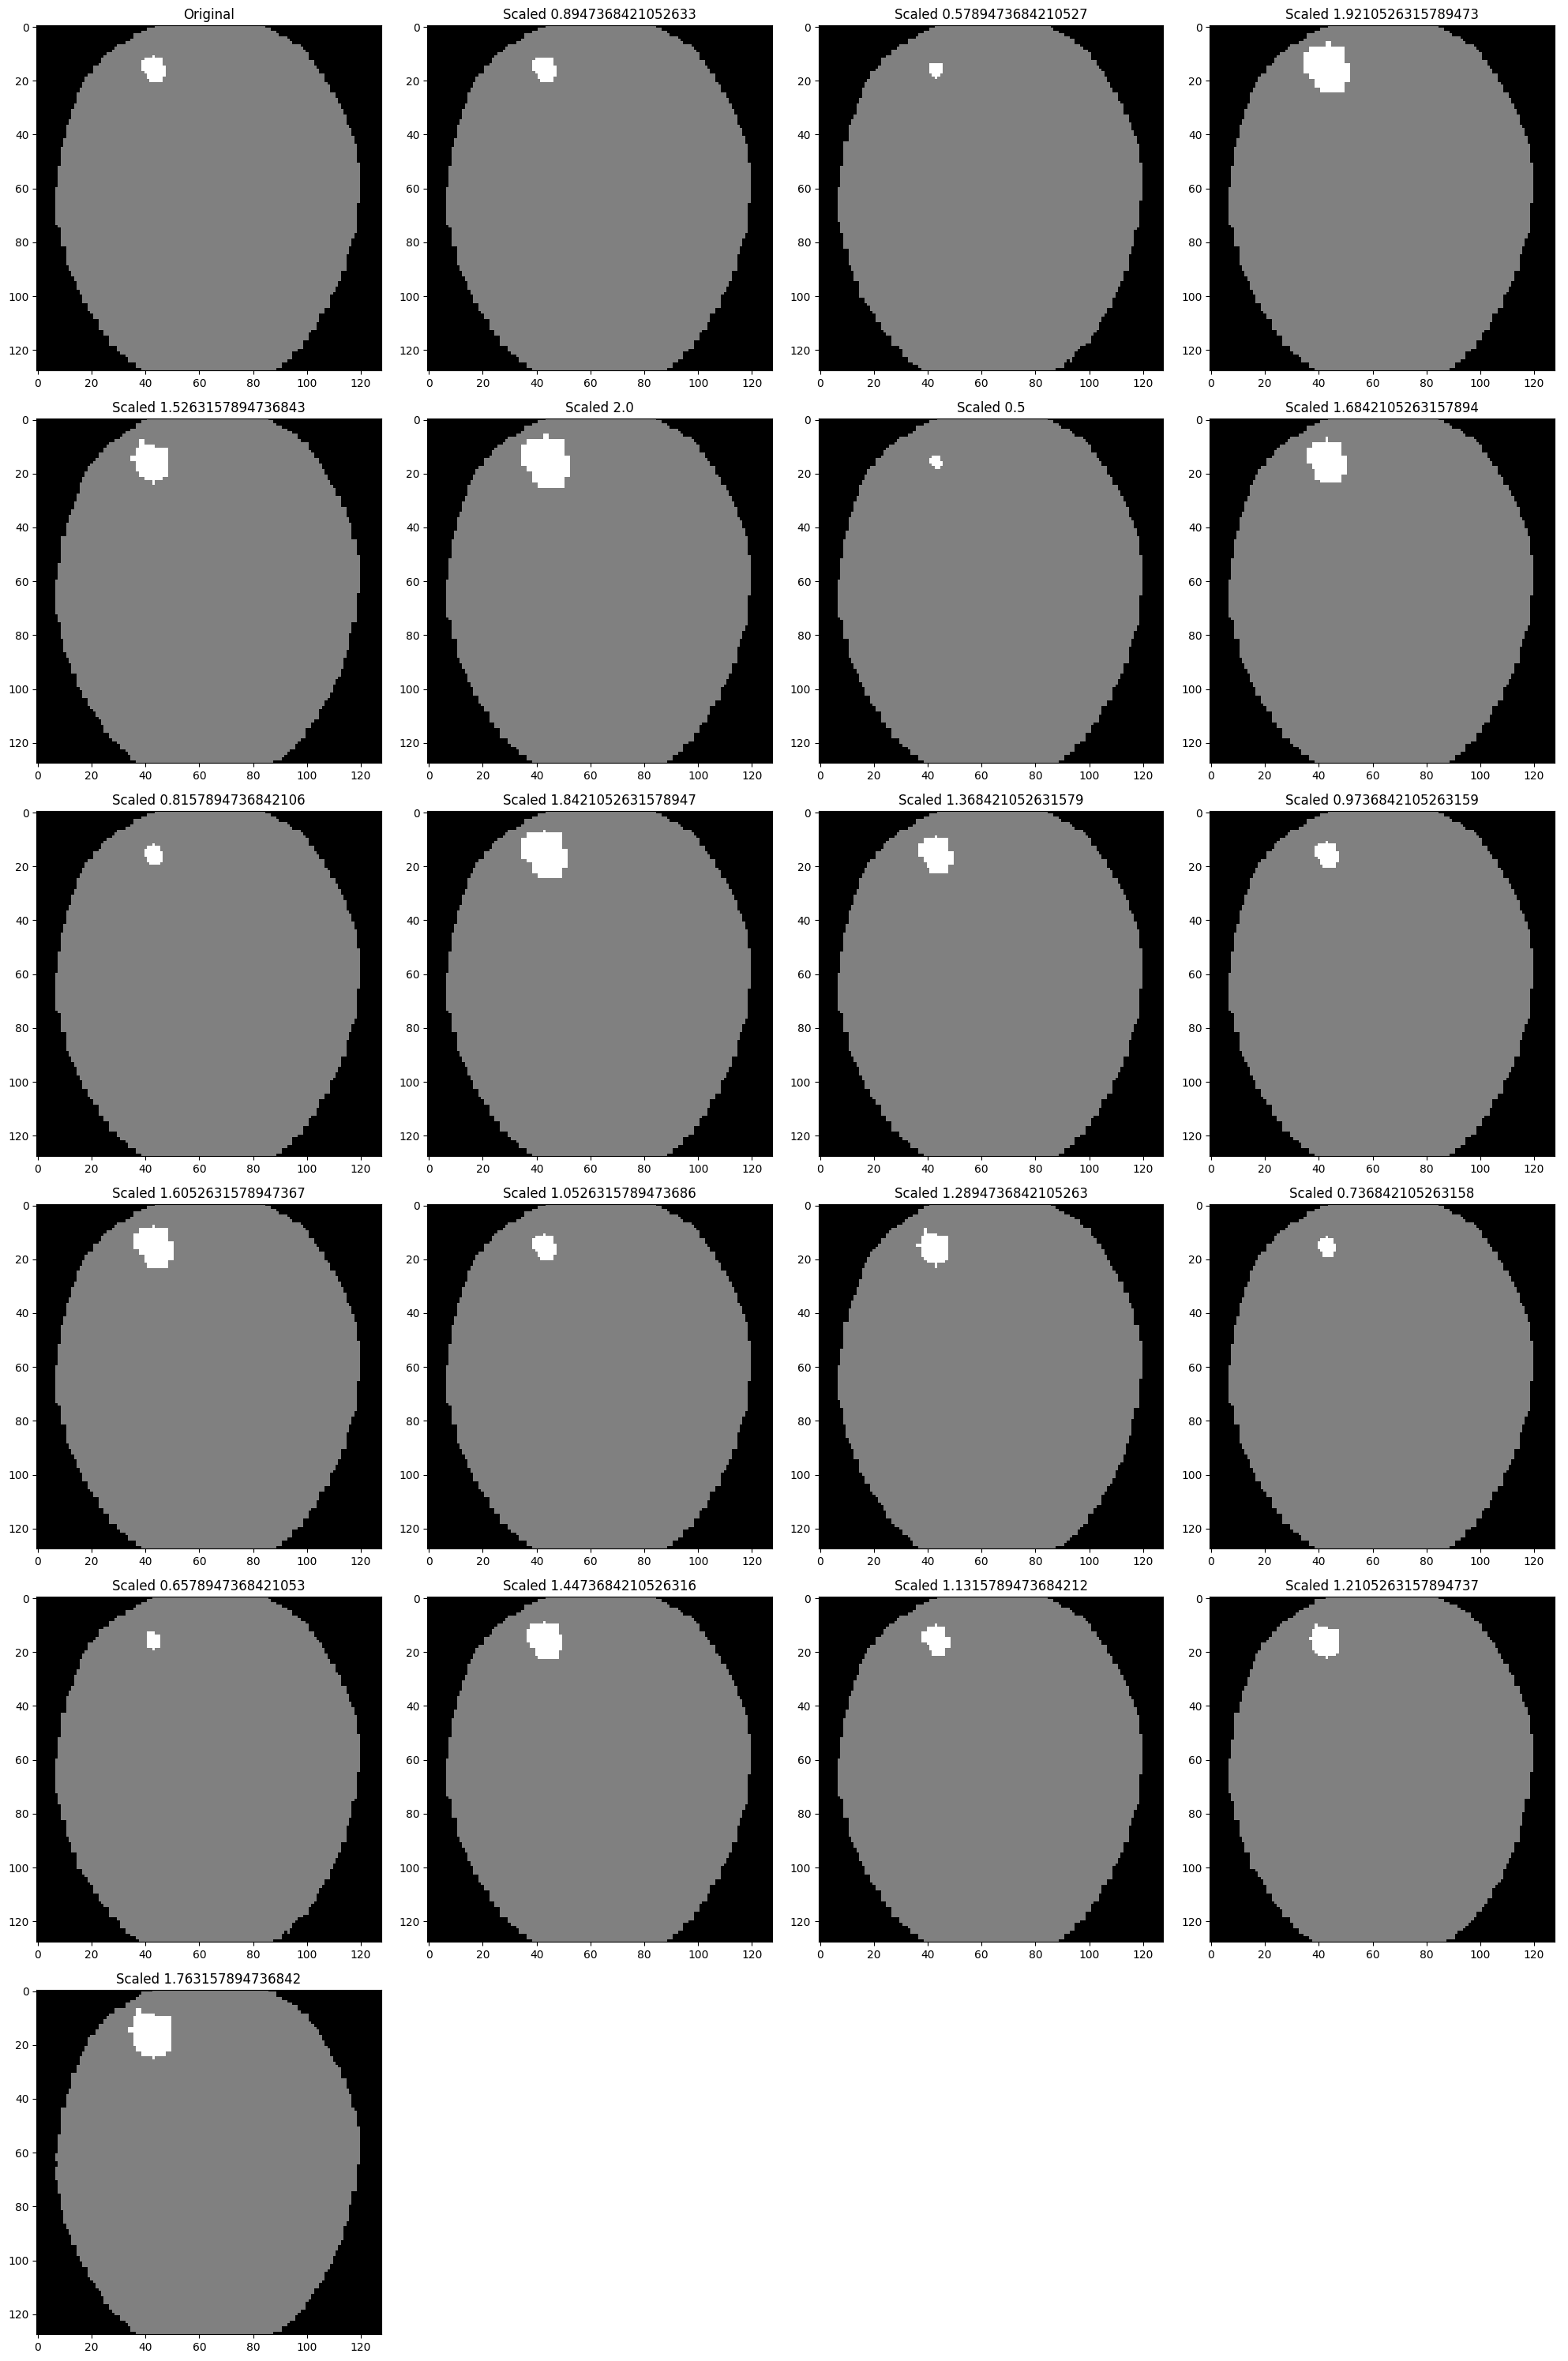

In [4]:
def find_largest_tumor_slice(img_array):
    """
    Find the index of the slice with the largest tumor area.

    :param img_array: 3D numpy array of the image.
    :return: Index of the slice with the largest tumor.
    """
    tumor_areas = np.sum(img_array == 2, axis=(1, 2))  # Assuming tumor label is 2
    return np.argmax(tumor_areas)

def plot_largest_tumor_slices(original_mask_path, scaled_masks_dir):
    """
    Plot the largest tumor slice of the original and scaled images in a grid layout with 4 columns.

    :param original_mask_path: Path to the original mask file.
    :param scaled_masks_dir: Directory containing scaled mask files.
    """
    # Load original mask and find largest tumor slice
    original_img = sitk.ReadImage(original_mask_path)
    original_img_array = sitk.GetArrayFromImage(original_img)
    largest_slice_original = find_largest_tumor_slice(original_img_array)

    # Fetch all scaled mask paths
    scaled_mask_paths = glob.glob(os.path.join(scaled_masks_dir, f"*_{os.path.basename(original_mask_path)}"))
    
    # Calculate number of rows for the subplot grid
    num_images = 1 + len(scaled_mask_paths)
    num_rows = (num_images + 3) // 4  # Ensure at least one row and calculate required number of rows

    # Create subplots with 4 columns and calculated number of rows
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    # Plot original image
    axes[0].imshow(original_img_array[largest_slice_original], cmap='gray')
    axes[0].set_title("Original")

    # Plot each scaled image
    for i, scaled_mask_path in enumerate(scaled_mask_paths):
        scaled_img = sitk.ReadImage(scaled_mask_path)
        scaled_img_array = sitk.GetArrayFromImage(scaled_img)
        largest_slice_scaled = find_largest_tumor_slice(scaled_img_array)

        axes[i + 1].imshow(scaled_img_array[largest_slice_scaled], cmap='gray')
        scale_factor = os.path.basename(scaled_mask_path).split("_")[0]  # Assuming filename format is 'scale_factor_filename'
        axes[i + 1].set_title(f"Scaled {scale_factor}")

    # Hide any unused axes
    for j in range(i + 2, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
mask_list = sorted(glob.glob(os.path.join(input_directory, "*.nii.gz")))
scaled_masks_dir = "dataset/scaled_masks/"
plot_largest_tumor_slices(mask_list[0], scaled_masks_dir)


### 2. Shift tumor mask in x, y, and z directions within head mask area, with specified range and step size for shifting:

In [5]:
output_directory = "dataset/shifted_masks"

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

def process_shift(args):
    mask, x_shift, y_shift, z_shift, name, brain_mask = args
    img = sitk.ReadImage(mask)
    img_array = sitk.GetArrayFromImage(img)
    original_tumor_mask = img_array == 2
    brain_mask = img_array == 1

    # Shift the tumor mask
    shifted_tumor_mask = shift(original_tumor_mask, [x_shift, y_shift, z_shift], mode='constant')
    
    # Ensure the shifted tumor stays within the brain area
    shifted_tumor_within_brain = np.logical_and(shifted_tumor_mask, brain_mask)

    # Check if at least half of the tumor is still within the brain
    original_tumor_area = np.sum(original_tumor_mask)
    shifted_tumor_within_brain_area = np.sum(shifted_tumor_within_brain)
    if shifted_tumor_within_brain_area < original_tumor_area / 2:
        return  # Skip further processing if more than half of the tumor is outside the brain

    # Fill the original tumor position with brain tissue
    img_array[original_tumor_mask] = 1

    # Overlay the shifted tumor onto the brain
    final_mask = np.where(shifted_tumor_within_brain, 2, img_array)
    final_mask_img = sitk.GetImageFromArray(final_mask)
    final_mask_img.CopyInformation(img)

    sitk.WriteImage(final_mask_img, f"{output_directory}/{x_shift}_{y_shift}_{z_shift}__{name}")

def shiftTumor(mask, shift_range, step):
    name = mask.split("/")[-1]
    img = sitk.ReadImage(mask)
    img_array = sitk.GetArrayFromImage(img)

    brain_mask = img_array == 1

    shift_args = [(mask, x_shift, y_shift, z_shift, name, brain_mask)
                  for x_shift in range(-shift_range, shift_range + 1, step)
                  for y_shift in range(-shift_range, shift_range + 1, step)
                  for z_shift in range(-shift_range, shift_range + 1, step)]

    with Pool() as pool:
        pool.map(process_shift, shift_args)

mask_list = sorted(glob.glob(f"{input_directory}/*.nii.gz"))
for mask_path in tqdm(mask_list):
    shiftTumor(mask_path, 40, 10)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.75s/it]


#### Largest tumor slice comparison between each shifted image and original image:

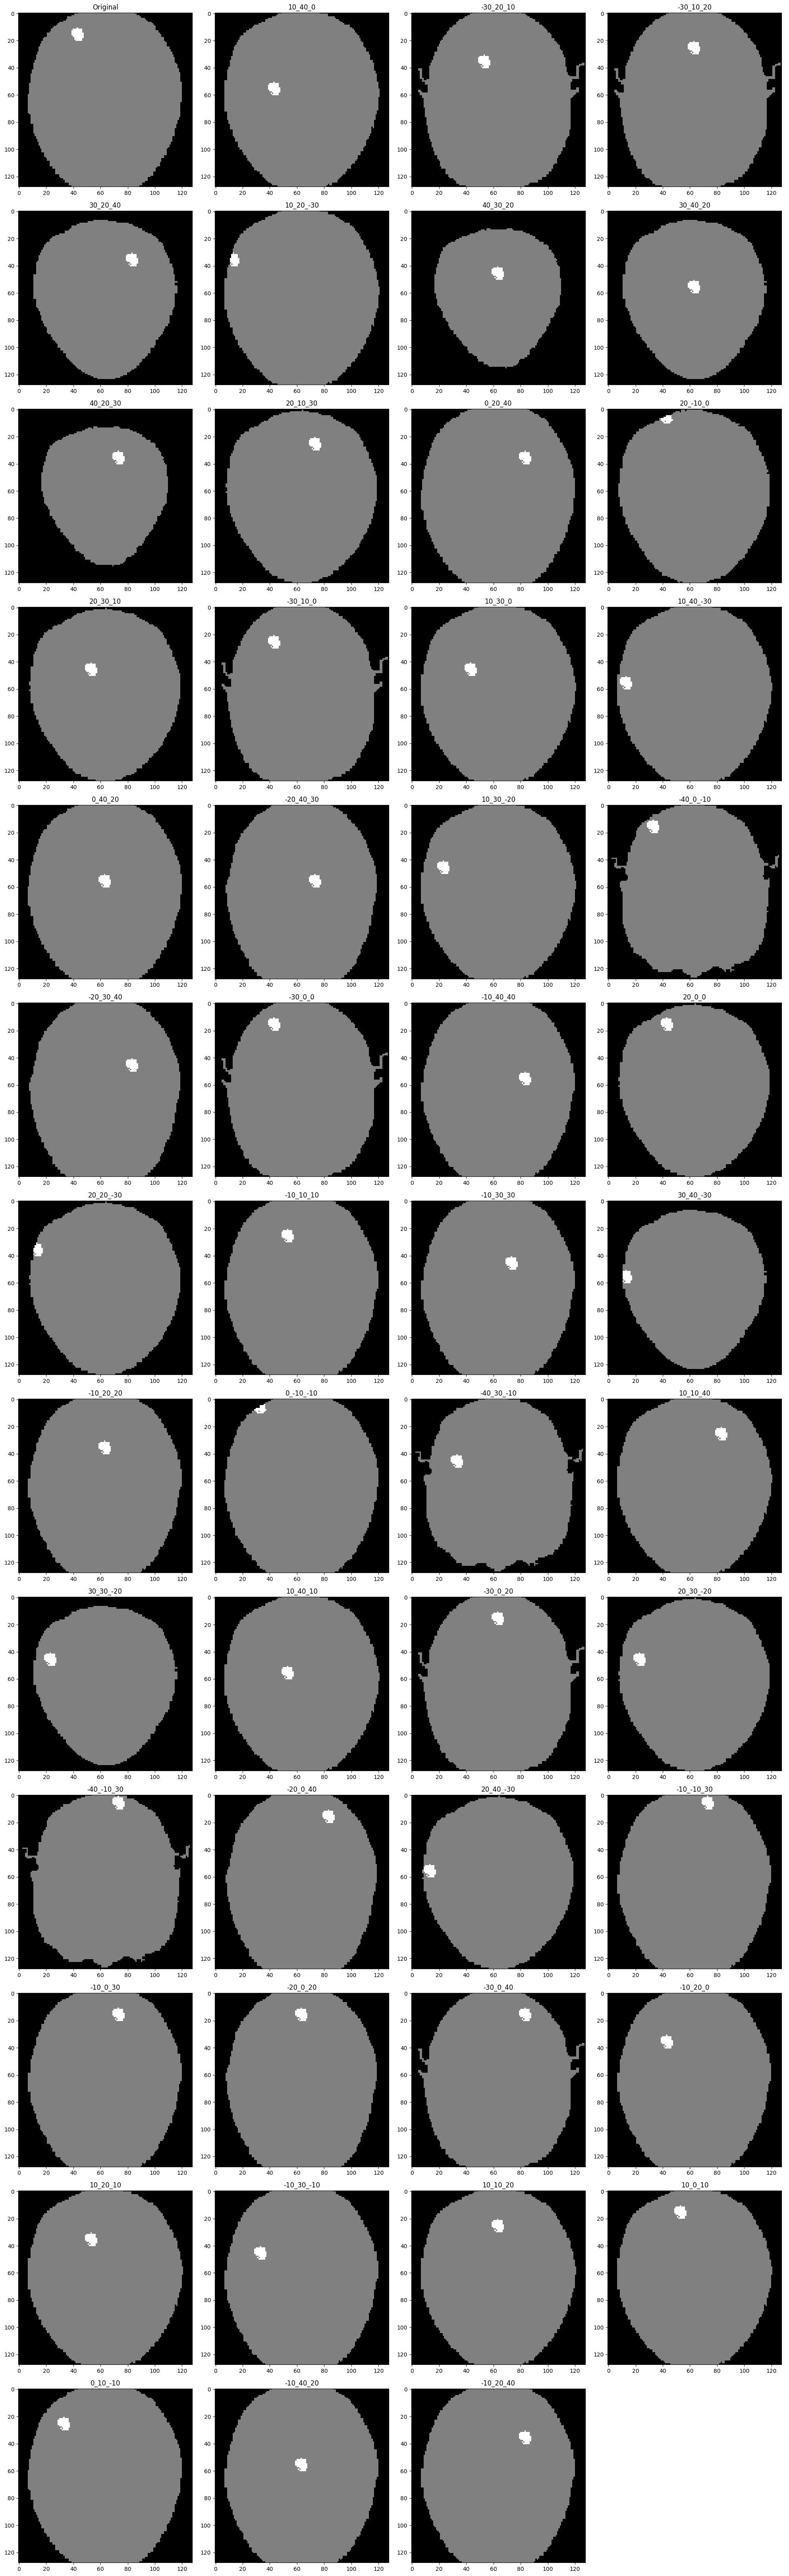

In [6]:
def find_largest_tumor_slice(img_path):
    """
    Find the index of the slice with the largest tumor area in the given image file.

    :param img_path: Path to the image file.
    :return: Index of the slice with the largest tumor.
    """
    img = sitk.ReadImage(img_path)
    img_array = sitk.GetArrayFromImage(img)
    tumor_areas = np.sum(img_array == 2, axis=(1, 2))  # Assuming tumor label is 2
    return np.argmax(tumor_areas)

def plot_largest_tumor_slice(ax, img_path, title):
    """
    Plot the largest tumor slice of an image on the given axes.

    :param ax: Matplotlib axes to plot on.
    :param img_path: Path to the image file.
    :param title: Title for the plot.
    """
    img = sitk.ReadImage(img_path)
    img_array = sitk.GetArrayFromImage(img)
    largest_slice = find_largest_tumor_slice(img_path)
    ax.imshow(img_array[largest_slice], cmap='gray')
    ax.set_title(title)

def plot_largest_tumor_slices(original_mask_path, scaled_masks_dir):
    """
    Plot the largest tumor slice of the original and scaled images in a grid layout with 4 columns.

    :param original_mask_path: Path to the original mask file.
    :param scaled_masks_dir: Directory containing scaled mask files.
    """
    # Fetch all scaled mask paths
    scaled_mask_paths = glob.glob(os.path.join(scaled_masks_dir, f"*_{os.path.basename(original_mask_path)}"))[:50]

    # Calculate number of rows for the subplot grid
    num_images = 1 + len(scaled_mask_paths)
    num_rows = (num_images + 3) // 4  # Ensure at least one row and calculate required number of rows

    # Create subplots with 4 columns and calculated number of rows
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    # Plot original image
    plot_largest_tumor_slice(axes[0], original_mask_path, "Original")

    # Plot each scaled image
    for i, scaled_mask_path in enumerate(scaled_mask_paths):
        scale_factor = os.path.basename(scaled_mask_path).split("__")[0]  # Assuming filename format is 'scale_factor_filename'
        plot_largest_tumor_slice(axes[i + 1], scaled_mask_path, f"{scale_factor}")

    # Hide any unused axes
    for j in range(i + 2, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
mask_list = sorted(glob.glob(os.path.join(input_directory, "*.nii.gz")))
shifted_masks_dir = "dataset/shifted_masks/"
plot_largest_tumor_slices(mask_list[0], shifted_masks_dir)
